In [2]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_excel("BlinkIT Grocery Data.xlsx", sheet_name="BlinkIT Grocery Data")
# Display basic info
print("Initial dataset info:")
print(df.info())

Initial dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item Fat Content           8523 non-null   object 
 1   Item Identifier            8523 non-null   object 
 2   Item Type                  8523 non-null   object 
 3   Outlet Establishment Year  8523 non-null   int64  
 4   Outlet Identifier          8523 non-null   object 
 5   Outlet Location Type       8523 non-null   object 
 6   Outlet Size                8523 non-null   object 
 7   Outlet Type                8523 non-null   object 
 8   Item Visibility            8523 non-null   float64
 9   Item Weight                7060 non-null   float64
 10  Sales                      8523 non-null   float64
 11  Rating                     8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None


In [ ]:
import pandas as pd
from pymongo import MongoClient

# Load Excel  
df = pd.read_excel("BlinkIT Grocery Data.xlsx", sheet_name="BlinkIT Grocery Data")
df['Item Weight'] = df['Item Weight'].fillna(df['Item Weight'].mean())
df['Outlet Age'] = 2025 - df['Outlet Establishment Year']
df['Item Fat Content'] = df['Item Fat Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})
original_df = df.copy()

In [12]:
from pymongo import MongoClient

# Connect to MongoDB (local default)
client = MongoClient("mongodb://localhost:27017/")

# Create/use database
db = client["BlinkitSalesDB"]

# Create/use collection
collection = db["sales_data"]

# Convert DataFrame to dict and insert
data_dict = df.to_dict(orient='records')
collection.insert_many(data_dict)

print("Upload complete. Records inserted:", collection.count_documents({}))

Upload complete. Records inserted: 8523


In [13]:
import pandas as pd
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")

# Access database and collection
db = client["BlinkitSalesDB"]
collection = db["sales_data"]

# Load data from MongoDB and convert to DataFrame
data = list(collection.find())
df = pd.DataFrame(data)

# Optional: Drop MongoDB internal ID field
df.drop(columns=['_id'], inplace=True)

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, sum as _sum

# Start Spark session
spark = SparkSession.builder \
    .appName("BlinkIT Sales Analysis") \
    .getOrCreate()

# Convert to Spark DataFrame
spark_df = spark.createDataFrame(df)

# 1. Average and Total Sales by Item Type
sales_by_item_type = spark_df.groupBy("Item Type").agg(
    avg("Sales").alias("Average_Sales"),
    _sum("Sales").alias("Total_Sales")
).orderBy("Item Type")

# 2. Average and Total Sales by Outlet Type
sales_by_outlet_type = spark_df.groupBy("Outlet Type").agg(
    avg("Sales").alias("Average_Sales"),
    _sum("Sales").alias("Total_Sales")
).orderBy("Outlet Type")

# 3. Average and Total Sales by Outlet Location Type
sales_by_location_type = spark_df.groupBy("Outlet Location Type").agg(
    avg("Sales").alias("Average_Sales"),
    _sum("Sales").alias("Total_Sales")
).orderBy("Outlet Location Type")

# Show results
sales_by_item_type.show(truncate=False)
sales_by_outlet_type.show(truncate=False)
sales_by_location_type.show(truncate=False)


+---------------------+------------------+------------------+
|Item Type            |Average_Sales     |Total_Sales       |
+---------------------+------------------+------------------+
|Baking Goods         |126.38076604938269|81894.73639999998 |
|Breads               |140.95266852589646|35379.11980000001 |
|Breakfast            |141.78815090909092|15596.6966        |
|Canned               |139.7638351309707 |90706.72899999999 |
|Dairy                |148.4992105571847 |101276.46159999998|
|Frozen Foods         |138.5033661214953 |118558.88139999998|
|Fruits and Vegetables|144.5812345779221 |178124.081        |
|Hard Drinks          |137.07794672897194|29334.680599999996|
|Health and Hygiene   |130.8189207692308 |68025.83880000001 |
|Household            |149.42475318681318|135976.52539999998|
|Meat                 |139.88203247058826|59449.863800000014|
|Others               |132.8514295857988 |22451.8916        |
|Seafood              |141.84171874999998|9077.869999999999 |
|Snack F

In [15]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder \
    .appName("FatContentDistribution") \
    .getOrCreate()

# Group and count
distribution = spark_df.groupBy("Outlet Size", "Item Fat Content").count().orderBy("Outlet Size", "Item Fat Content")

# Show result
distribution.show(truncate=False)


+-----------+----------------+-----+
|Outlet Size|Item Fat Content|count|
+-----------+----------------+-----+
|High       |Low Fat         |853  |
|High       |Regular         |900  |
|Medium     |Low Fat         |2429 |
|Medium     |Regular         |1202 |
|Small      |Low Fat         |2235 |
|Small      |Regular         |904  |
+-----------+----------------+-----+



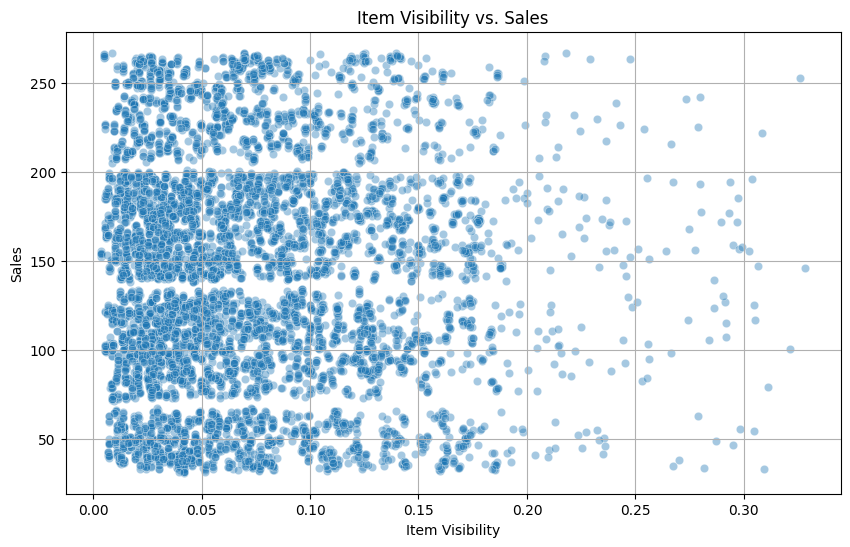

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Remove items with 0 visibility
df_filtered = df[df['Item Visibility'] > 0]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x="Item Visibility", y="Sales", alpha=0.4)
plt.title("Item Visibility vs. Sales")
plt.xlabel("Item Visibility")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, avg

# Initialize Spark
spark = SparkSession.builder.appName("VisibilitySalesTrend").getOrCreate()

# Assuming df is loaded from MongoDB as a Pandas DataFrame, then:
spark_df = spark.createDataFrame(df)

# Optional: Filter out 0 visibility
filtered_df = spark_df.filter(spark_df["Item Visibility"] > 0)

# Create visibility bins
binned_df = filtered_df.withColumn("Visibility Level", when(filtered_df["Item Visibility"] < 0.05, "Low")
                                                     .when(filtered_df["Item Visibility"] < 0.1, "Medium")
                                                     .otherwise("High"))

# Group by visibility level and calculate average sales
visibility_sales_trend = binned_df.groupBy("Visibility Level").agg(
    avg("Sales").alias("Average Sales")
).orderBy("Visibility Level")

# Show result
visibility_sales_trend.show()


+----------------+------------------+
|Visibility Level|     Average Sales|
+----------------+------------------+
|            High|138.32952279792747|
|             Low| 139.6744040283688|
|          Medium|145.43808615263572|
+----------------+------------------+



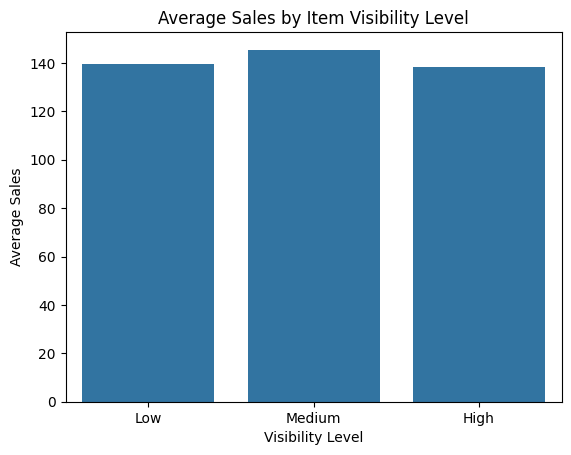

In [18]:
trend_df = visibility_sales_trend.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=trend_df, x="Visibility Level", y="Average Sales", order=["Low", "Medium", "High"])
plt.title("Average Sales by Item Visibility Level")
plt.xlabel("Visibility Level")
plt.ylabel("Average Sales")
plt.show()

In [19]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, sum as _sum

# Start Spark session (if not already started)
spark = SparkSession.builder.appName("OutletSalesTrend").getOrCreate()

# Convert from pandas DataFrame to Spark DataFrame (if data was loaded from MongoDB)

# Group by Outlet Establishment Year and calculate total and average sales
sales_by_year = spark_df.groupBy("Outlet Establishment Year").agg(
    avg("Sales").alias("Average Sales"),
    _sum("Sales").alias("Total Sales")
).orderBy("Outlet Establishment Year")

# Show result
sales_by_year.show()

+-------------------------+------------------+------------------+
|Outlet Establishment Year|     Average Sales|       Total Sales|
+-------------------------+------------------+------------------+
|                     2011|140.77759747747749|        78131.5666|
|                     2012| 140.2976987096775|130476.85980000006|
|                     2014|141.42598240343347|131809.01559999998|
|                     2015|140.95024779332616|130942.78020000001|
|                     2016|142.05738688172042|       132113.3698|
|                     2017| 143.1224806451613|        133103.907|
|                     2018|139.79648462064247|204522.25699999995|
|                     2020|139.42112354211662|       129103.9604|
|                     2022|141.67863836206894|131477.77639999997|
+-------------------------+------------------+------------------+



In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as _sum

# Start Spark session
spark = SparkSession.builder.appName("TopSellingItems").getOrCreate()

# Assuming your main Spark DataFrame is called `spark_df`
top_items = spark_df.groupBy("Item Type") \
    .agg(_sum("Sales").alias("Total Sales")) \
    .orderBy("Total Sales", ascending=False) \
    .limit(10)

top_items.show()


+--------------------+------------------+
|           Item Type|       Total Sales|
+--------------------+------------------+
|Fruits and Vegeta...|        178124.081|
|         Snack Foods|       175433.9224|
|           Household|135976.52539999998|
|        Frozen Foods|118558.88139999998|
|               Dairy|101276.46159999998|
|              Canned| 90706.72899999999|
|        Baking Goods| 81894.73639999998|
|  Health and Hygiene| 68025.83880000001|
|                Meat|59449.863800000014|
|         Soft Drinks| 58514.16699999999|
+--------------------+------------------+



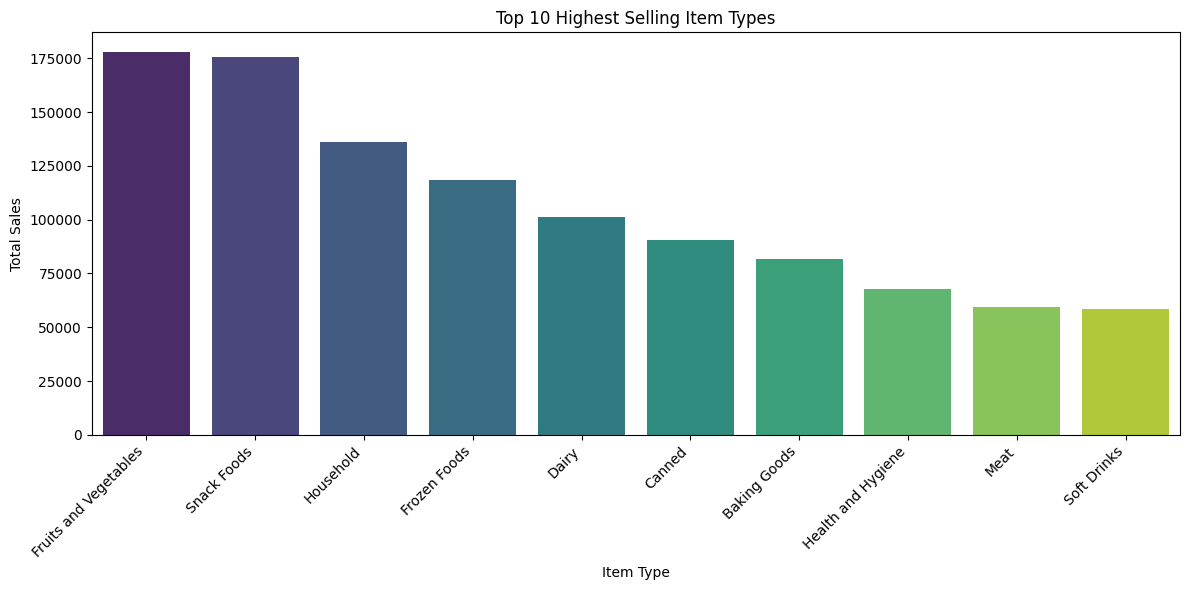

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas
top_items_df = top_items.toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_items_df, x="Item Type", y="Total Sales", hue="Item Type", palette="viridis", legend=False)
plt.title("Top 10 Highest Selling Item Types")
plt.xlabel("Item Type")
plt.ylabel("Total Sales")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [24]:
from pyspark.sql.functions import sum as _sum, avg
# Group by Outlet Identifier
sales_by_outlet = spark_df.groupBy("Outlet Identifier").agg(
    _sum("Sales").alias("Total Sales"),
    avg("Sales").alias("Average Sales")
).orderBy("Total Sales", ascending=False)

sales_by_outlet.show()

+-----------------+------------------+------------------+
|Outlet Identifier|       Total Sales|     Average Sales|
+-----------------+------------------+------------------+
|           OUT035|        133103.907| 143.1224806451613|
|           OUT046|       132113.3698|142.05738688172042|
|           OUT013|131809.01559999998|141.42598240343347|
|           OUT018|131477.77639999997|141.67863836206894|
|           OUT045|130942.78020000001|140.95024779332616|
|           OUT027|130714.67459999997|139.80179101604276|
|           OUT049|130476.85980000006| 140.2976987096775|
|           OUT017|       129103.9604|139.42112354211662|
|           OUT010|        78131.5666|140.77759747747749|
|           OUT019| 73807.58240000001| 139.7870878787879|
+-----------------+------------------+------------------+



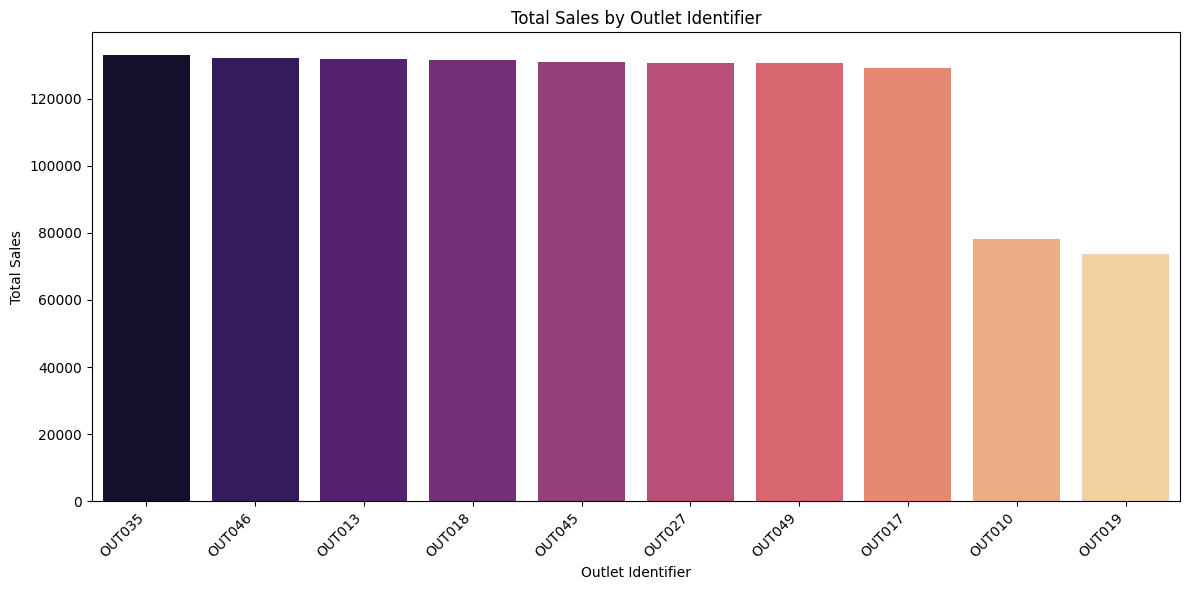

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas
sales_outlet_df = sales_by_outlet.toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=sales_outlet_df, x="Outlet Identifier", y="Total Sales", hue="Outlet Identifier", palette="magma", legend=False)
plt.title("Total Sales by Outlet Identifier")
plt.xlabel("Outlet Identifier")
plt.ylabel("Total Sales")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [26]:
from pyspark.sql.functions import avg

# Calculate average sales per outlet
outlet_sales = spark_df.groupBy("Outlet Identifier", "Outlet Size", "Outlet Type").agg(
    avg("Sales").alias("Average Sales")
)

In [27]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Index and one-hot encode Outlet_Size and Outlet_Type
indexers = [
    StringIndexer(inputCol="Outlet Size", outputCol="Outlet_Size_Idx", handleInvalid="keep"),
    StringIndexer(inputCol="Outlet Type", outputCol="Outlet_Type_Idx", handleInvalid="keep")
]

encoders = [
    OneHotEncoder(inputCol="Outlet_Size_Idx", outputCol="Outlet_Size_OneHot"),
    OneHotEncoder(inputCol="Outlet_Type_Idx", outputCol="Outlet_Type_OneHot")
]

# Assemble features
assembler = VectorAssembler(
    inputCols=["Outlet_Size_OneHot", "Outlet_Type_OneHot", "Average Sales"],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
outlet_prepared = pipeline.fit(outlet_sales).transform(outlet_sales)


In [28]:
from pyspark.ml.clustering import KMeans

# Set number of clusters
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=3, seed=42)
model = kmeans.fit(outlet_prepared)
clustered_outlets = model.transform(outlet_prepared)

# View clustered data
clustered_outlets.select("Outlet Identifier", "Outlet Size", "Outlet Type", "Average Sales", "cluster").show()

+-----------------+-----------+-----------------+------------------+-------+
|Outlet Identifier|Outlet Size|      Outlet Type|     Average Sales|cluster|
+-----------------+-----------+-----------------+------------------+-------+
|           OUT045|     Medium|Supermarket Type1|134.11076474164136|      1|
|           OUT010|     Medium|    Grocery Store|  140.294759245283|      0|
|           OUT018|     Medium|Supermarket Type2|141.67863836206894|      0|
|           OUT010|       High|    Grocery Store| 139.7859356223176|      0|
|           OUT049|     Medium|Supermarket Type1| 140.2976987096775|      0|
|           OUT045|      Small|Supermarket Type1|144.98195889570553|      2|
|           OUT017|       High|Supermarket Type1|143.49117006369428|      2|
|           OUT035|      Small|Supermarket Type1| 143.1224806451613|      2|
|           OUT013|       High|Supermarket Type1|141.42598240343347|      0|
|           OUT017|     Medium|Supermarket Type1|139.04046229508197|      0|

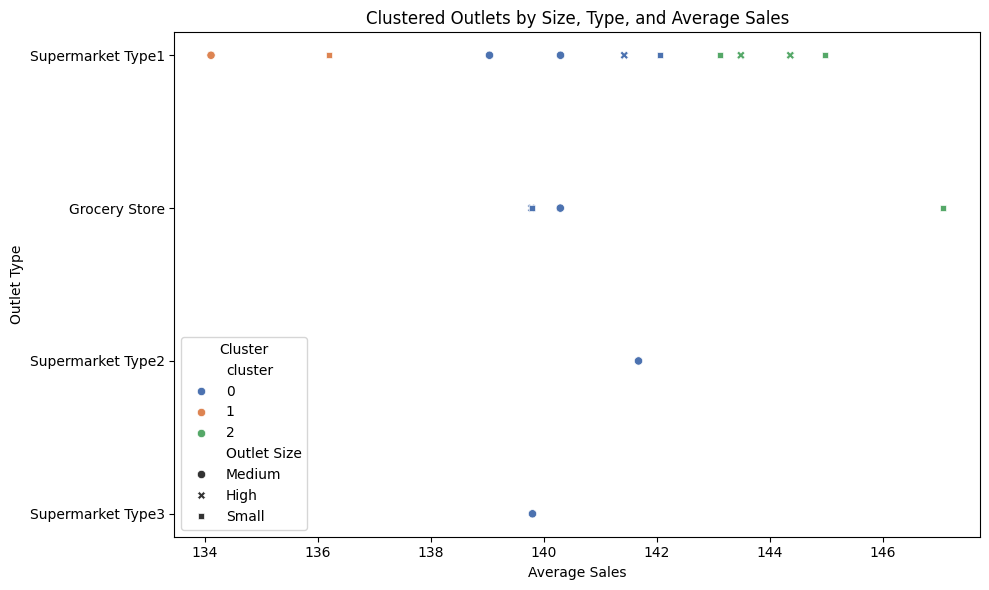

In [29]:
# Convert to Pandas
clustered_pd = clustered_outlets.select("Outlet Identifier", "Outlet Size", "Outlet Type", "Average Sales", "cluster").toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustered_pd, x="Average Sales", y="Outlet Type", hue="cluster", style="Outlet Size", palette="deep")
plt.title("Clustered Outlets by Size, Type, and Average Sales")
plt.xlabel("Average Sales")
plt.ylabel("Outlet Type")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [30]:
# Compute IQR for Item_Visibility
Q1 = df["Item Visibility"].quantile(0.25)
Q3 = df["Item Visibility"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out low and high visibility items
low_visibility = df[df["Item Visibility"] < lower_bound]
high_visibility = df[df["Item Visibility"] > upper_bound]

# Display results
print(f"Items with unusually LOW visibility: {len(low_visibility)}")
print(low_visibility[["Item Identifier", "Item Type", "Item Visibility"]].head())

print(f"\nItems with unusually HIGH visibility: {len(high_visibility)}")
print(high_visibility[["Item Identifier", "Item Type", "Item Visibility"]].head())


Items with unusually LOW visibility: 0
Empty DataFrame
Columns: [Item Identifier, Item Type, Item Visibility]
Index: []

Items with unusually HIGH visibility: 144
    Item Identifier              Item Type  Item Visibility
92            FDK02                 Canned         0.196491
93            FDI15                  Dairy         0.247490
109           FDF56  Fruits and Vegetables         0.209163
294           FDR48           Baking Goods         0.220111
302           NCN06              Household         0.201688


In [31]:
from pyspark.sql.functions import avg, sum as _sum

grouped_products = spark_df.groupBy("Item Type", "Item Fat Content").agg(
    avg("Sales").alias("Average Sales"),
    _sum("Sales").alias("Total Sales")
).orderBy("Total Sales", ascending=False)

grouped_products.show()

+--------------------+----------------+------------------+------------------+
|           Item Type|Item Fat Content|     Average Sales|       Total Sales|
+--------------------+----------------+------------------+------------------+
|           Household|         Low Fat|149.42475318681318|135976.52539999998|
|         Snack Foods|         Low Fat|156.49817543352603|108296.73740000001|
|Fruits and Vegeta...|         Regular|152.97757076411958| 92092.49759999999|
|Fruits and Vegeta...|         Low Fat|136.55806888888887| 86031.58339999999|
|  Health and Hygiene|         Low Fat| 130.8189207692308| 68025.83880000001|
|         Snack Foods|         Regular|132.15981299212598|         67137.185|
|        Frozen Foods|         Low Fat| 139.0194902222222|62558.770599999996|
|               Dairy|         Low Fat|147.11599330143542| 61494.48520000001|
|        Frozen Foods|         Regular|137.93130738916255|        56000.1108|
|         Soft Drinks|         Low Fat|133.33803475935827| 49868

In [32]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

indexers = [
    StringIndexer(inputCol="Item Type", outputCol="Item_Type_Idx", handleInvalid="keep"),
    StringIndexer(inputCol="Item Fat Content", outputCol="Fat_Content_Idx", handleInvalid="keep")
]

encoders = [
    OneHotEncoder(inputCol="Item_Type_Idx", outputCol="Item_Type_OH"),
    OneHotEncoder(inputCol="Fat_Content_Idx", outputCol="Fat_Content_OH")
]

assembler = VectorAssembler(
    inputCols=["Item_Type_OH", "Fat_Content_OH", "Sales"],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
prepared_data = pipeline.fit(spark_df).transform(spark_df)

In [34]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=4, seed=1)
model = kmeans.fit(prepared_data)
clustered_products = model.transform(prepared_data)

# Show clustered result
clustered_products.select("Item Type", "Item Fat Content", "Sales", "cluster").show()


+--------------------+----------------+--------+-------+
|           Item Type|Item Fat Content|   Sales|cluster|
+--------------------+----------------+--------+-------+
|Fruits and Vegeta...|         Regular|145.4786|      2|
|  Health and Hygiene|         Low Fat|115.3492|      0|
|        Frozen Foods|         Regular| 165.021|      2|
|              Canned|         Regular|126.5046|      0|
|         Soft Drinks|         Low Fat| 55.1614|      3|
|        Frozen Foods|         Low Fat|102.4016|      0|
|  Health and Hygiene|         Low Fat| 81.4618|      0|
|           Household|         Low Fat| 96.0726|      0|
|Fruits and Vegeta...|         Low Fat| 124.173|      0|
|              Canned|         Low Fat|181.9292|      2|
|         Snack Foods|         Low Fat|109.8912|      0|
|  Health and Hygiene|         Low Fat|192.1846|      2|
|Fruits and Vegeta...|         Low Fat|112.3886|      0|
|           Household|         Low Fat| 195.211|      2|
|                Meat|         

In [36]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")

# Access database and collection
db = client["BlinkitSalesDB"]
collection = db["sales_data"]

# Load data from MongoDB and convert to DataFrame
data = list(collection.find())
df = pd.DataFrame(data)

# Optional: Drop MongoDB internal ID field
df.drop(columns=['_id'], inplace=True)
# Drop unwanted identifiers
df = df.drop(columns=["Item Identifier", "Outlet Identifier"])

# Define features and target
features = ["Item Type", "Outlet Location Type", "Outlet Size", "Outlet Type", "Item Visibility", "Item Weight", "Rating"]
target = "Sales_Class"

# Fill missing values in numeric columns
df["Item Weight"] = df["Item Weight"].fillna(df["Item Weight"].mean())

# Create classification target: 1 if Sales > mean, else 0
df["Sales_Class"] = (df["Sales"] > df["Sales"].mean()).astype(int)

# Split data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Categorical and numerical features
categorical_features = ["Item Type", "Outlet Location Type", "Outlet Size", "Outlet Type"]
numerical_features = ["Item Visibility", "Item Weight", "Rating"]

# Preprocessing pipelines
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_features),
    ("num", num_pipeline, numerical_features)
])

# ---------- XGBOOST WITH HYPERPARAMETER TUNING ----------
print("\n=== XGBoost with Hyperparameter Tuning ===")
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Define hyperparameter grid for XGBoost
xgb_param_grid = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__learning_rate": [0.01, 0.1, 0.3],
    "classifier__max_depth": [3, 6, 10],
    "classifier__min_child_weight": [1, 5, 10],
    "classifier__subsample": [0.8, 1.0],
    "classifier__colsample_bytree": [0.8, 1.0],
    "classifier__gamma": [0, 0.1, 0.5]
}

# Perform GridSearchCV
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, n_jobs=-1, verbose=2, scoring="accuracy")
xgb_grid_search.fit(X_train, y_train)

# Best XGBoost model
print("Best XGBoost Model:", xgb_grid_search.best_params_)
xgb_pred = xgb_grid_search.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("Precision:", precision_score(y_test, xgb_pred))
print("Recall:", recall_score(y_test, xgb_pred))
print("F1 Score:", f1_score(y_test, xgb_pred))
print("\nClassification Report:\n", classification_report(y_test, xgb_pred))


=== XGBoost with Hyperparameter Tuning ===
Fitting 5 folds for each of 972 candidates, totalling 4860 fits


C:\Users\HP R5\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:40:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Model: {'classifier__colsample_bytree': 1.0, 'classifier__gamma': 0, 'classifier__learning_rate': 0.3, 'classifier__max_depth': 10, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Accuracy: 0.8134897360703812
Precision: 0.7971334068357222
Recall: 0.8436406067677946
F1 Score: 0.8197278911564626

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.81       848
           1       0.80      0.84      0.82       857

    accuracy                           0.81      1705
   macro avg       0.81      0.81      0.81      1705
weighted avg       0.81      0.81      0.81      1705



In [37]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ---------- XGBOOST REGRESSOR ----------
print("\n=== XGBoost Regressor ===")

xgb_reg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(objective="reg:squarederror", random_state=42))
])

# Fit model
xgb_reg_pipeline.fit(X_train, df.loc[X_train.index, "Sales"])

# Predict
xgb_reg_pred = xgb_reg_pipeline.predict(X_test)

# Evaluate
r2 = r2_score(df.loc[X_test.index, "Sales"], xgb_reg_pred)
rmse = np.sqrt(mean_squared_error(df.loc[X_test.index, "Sales"], xgb_reg_pred))

print("R2 Score:", r2)
print("RMSE:", rmse)


=== XGBoost Regressor ===
R2 Score: 0.4892540320578974
RMSE: 44.98079303609719


In [40]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import numpy as np

# ---------- XGBOOST REGRESSOR WITH HYPERPARAMETER TUNING ----------
print("\n=== XGBoost Regressor with Hyperparameter Tuning ===")

# Define the parameter grid for tuning
param_grid = {
    "regressor__learning_rate": [0.01, 0.1, 0.2],
    "regressor__n_estimators": [100, 200, 300],
    "regressor__max_depth": [3, 5, 7],
    "regressor__subsample": [0.8, 0.9, 1.0],
    "regressor__colsample_bytree": [0.8, 0.9, 1.0]
}

# Create a pipeline with the preprocessor and the XGBRegressor
xgb_reg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(objective="reg:squarederror", random_state=42))
])

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_reg_pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, df.loc[X_train.index, "Sales"])

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Predict using the best model
xgb_reg_pred = best_xgb_model.predict(X_test)

# Evaluate the model
r2 = r2_score(df.loc[X_test.index, "Sales"], xgb_reg_pred)
rmse = np.sqrt(mean_squared_error(df.loc[X_test.index, "Sales"], xgb_reg_pred))

# Print the results
print("Best Hyperparameters:", grid_search.best_params_)
print("R2 Score:", r2)
print("RMSE:", rmse)



=== XGBoost Regressor with Hyperparameter Tuning ===
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Hyperparameters: {'regressor__colsample_bytree': 0.9, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 7, 'regressor__n_estimators': 300, 'regressor__subsample': 1.0}
R2 Score: 0.6373097043527317
RMSE: 37.90465973289201


In [41]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE
mape = mean_absolute_percentage_error(df.loc[X_test.index, "Sales"], xgb_reg_pred)

# Accuracy as 100 - MAPE
accuracy = 100 - (mape * 100)

print("MAPE:", mape)  
print("Accuracy (approx):", accuracy, "%")

MAPE: 0.25853694730997584
Accuracy (approx): 74.14630526900241 %


In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

# Load data
client = MongoClient("mongodb://localhost:27017/")

# Access database and collection
db = client["BlinkitSalesDB"]
collection = db["sales_data"]

# Load data from MongoDB and convert to DataFrame
data = list(collection.find())
df = pd.DataFrame(data)

# Optional: Drop MongoDB internal ID field
df.drop(columns=['_id'], inplace=True)

# Features and target
features = ["Item Type", "Item Fat Content", "Item Visibility", "Item Weight", 
            "Outlet Size", "Outlet Location Type", "Outlet Type"]
target = "Sales"

X = df[features]
y = df[target]

# Categorical and numerical columns
categorical_cols = ["Item Type", "Item Fat Content", "Outlet Size", "Outlet Location Type", "Outlet Type"]
numerical_cols = ["Item Visibility", "Item Weight"]

# Preprocessing
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
    ]), numerical_cols)
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    "XGBoost": XGBRegressor(objective="reg:squarederror", random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}

# Parameter grids
param_grids = {
    "XGBoost": {
        "regressor__n_estimators": [100, 200],
        "regressor__max_depth": [3, 6],
        "regressor__learning_rate": [0.05, 0.1]
    },
    "Gradient Boosting": {
        "regressor__n_estimators": [100, 200],
        "regressor__max_depth": [3, 6],
        "regressor__learning_rate": [0.05, 0.1]
    },
    "CatBoost": {
        "regressor__depth": [4, 6],
        "regressor__learning_rate": [0.05, 0.1],
        "regressor__iterations": [100, 200]
    }
}

# Results list
results = []

# Run tuning and evaluation
for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

    grid_search = GridSearchCV(pipeline, param_grids[name], cv=3, scoring="r2", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    accuracy = 100 - (mape * 100)

    results.append({
        "Model": name + " (Tuned)",
        "Best Params": grid_search.best_params_,
        "RMSE": round(rmse, 2),
        "R²": round(r2, 4),
        "MAPE": round(mape, 4),
        "Accuracy (%)": round(accuracy, 2)
    })

# Convert to DataFrame for comparison
results_df = pd.DataFrame(results).sort_values(by="Accuracy (%)", ascending=False)
print(results_df)

                       Model  \
0            XGBoost (Tuned)   
1  Gradient Boosting (Tuned)   
2           CatBoost (Tuned)   

                                         Best Params   RMSE      R²    MAPE  \
0  {'regressor__learning_rate': 0.1, 'regressor__...  45.63  0.4743  0.3885   
1  {'regressor__learning_rate': 0.1, 'regressor__...  45.71  0.4726  0.3912   
2  {'regressor__depth': 6, 'regressor__iterations...  55.23  0.2300  0.5011   

   Accuracy (%)  
0         61.15  
1         60.88  
2         49.89  
